<a href="https://colab.research.google.com/github/RoshanM-18/MachineHack-hackathons/blob/main/news_category_prediction_machinehack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-8e937065-7bee-b307-49e7-fd4b178176bf)


In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import zipfile
import random

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
dir = "/content/drive/MyDrive/Data.zip"
zip_ref = zipfile.ZipFile(dir)
zip_ref.extractall()
zip_ref.close()

### preprocessing data

In [ ]:
train_df = pd.read_excel("/content/Participants_Data_News_category/Data_Train.xlsx")
train_df.head()

,STORY,SECTION
0,But the most painful was the huge reversal in ...,3.0
1,How formidable is the opposition alliance amon...,0.0
2,Most Asian currencies were trading lower today...,3.0
3,"If you want to answer any question, click on ‘...",1.0
4,"In global markets, gold prices edged up today ...",3.0


In [ ]:
test_df = pd.read_excel("/content/Participants_Data_News_category/Data_Test.xlsx")

In [ ]:
train_df.columns = [x.lower() for x in train_df.columns]

* 0 --> politics
* 1 --> technology
* 2 --> entertainment
* 3 --> business

In [ ]:
train_df.section.value_counts()

1.0    2772
2.0    1924
0.0    1686
3.0    1246
Name: section, dtype: int64

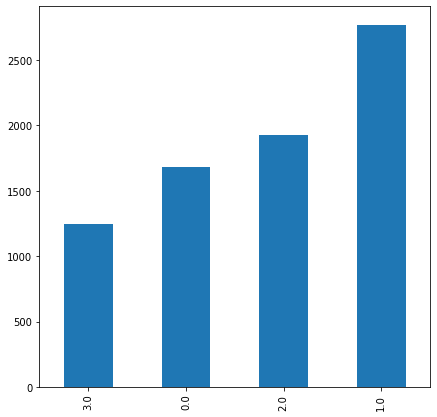

In [ ]:
train_df.section.value_counts().sort_values(ascending=True).plot(kind="bar", figsize=(7,7))

In [ ]:
train_sentences = train_df["story"].tolist()
train_labels = train_df["section"].tolist()

In [ ]:
# average length of the sentence
sent_len = [len(x.split()) for x in train_sentences]
average_sent_len = np.mean(sent_len)
average_sent_len

107.58927635028842

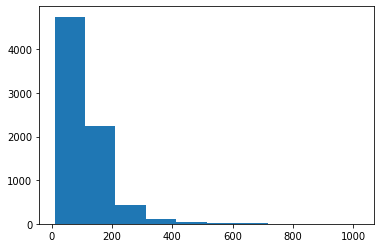

In [ ]:
plt.hist(sent_len)
plt.show()

In [ ]:
np.percentile(sent_len, 90)

199.0

In [ ]:
train_shuffled_dataset = train_df.sample(frac=1.0, random_state=42)

In [ ]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_shuffled_dataset["story"].to_numpy(), 
                                                                            train_shuffled_dataset["section"].to_numpy(), 
                                                                            stratify=train_shuffled_dataset["section"].to_numpy(),
                                                                            test_size=0.1)

In [ ]:
len(train_sentences), len(val_sentences)

(6865, 763)

In [ ]:
def calculate_result(y_true, y_pred):

  dictio = {}
  dictio["accuracy"] = accuracy_score(y_true, y_pred)
  dictio["precision"] = precision_score(y_true, y_pred, average="weighted")
  dictio["recall"] = recall_score(y_true, y_pred, average="weighted")
  dictio["f1"] = f1_score(y_true, y_pred, average="weighted")

  return dictio

### using prefetch dataset



In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels))
train_data = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels))
val_data = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### text vectorization and embedding layer

In [ ]:
text_vectorizer = keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=25000,
    output_sequence_length=200,
    pad_to_max_tokens=True
)

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
vocab = text_vectorizer.get_vocabulary()
len(vocab)

25000

In [ ]:
vocab[:10], vocab[-10:]

(['', '[UNK]', 'the', 'to', 'and', 'of', 'in', 'a', 'is', 'on'],
 ['underwriting',
  'underwhelming',
  'underwhelmed',
  'undervalued',
  'underutilized',
  'underutilization',
  'underused',
  'underthehood',
  'undersupply',
  'undersubscription'])

In [ ]:
embedding = keras.layers.Embedding(
    input_dim=len(vocab),
    output_dim=128,
    mask_zero=True,
    name="embedding_layer"
)

### Model 0 - Simple CNN model

(96.215, 314)

In [ ]:
inputs = keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = keras.layers.Conv1D(64, 5, activation="relu")(x)
x = keras.layers.MaxPool1D()(x)
x = keras.layers.Conv1D(28, 5, activation="relu")(x)
x = keras.layers.GlobalMaxPooling1D()(x)
x = keras.layers.Dense(128, activation="relu")(x)
outputs = keras.layers.Dense(4, activation="softmax")(x)

model_0 = keras.Model(inputs, outputs)

model_0.compile(loss=keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"],
                optimizer=keras.optimizers.Adam())

history_model_0 = model_0.fit(train_data, steps_per_epoch=len(train_data),
                              epochs=10, validation_data=val_data, validation_steps=len(val_data))

Epoch 1/10
215/215 [==============================] - 27s 120ms/step - loss: 0.7373 - accuracy: 0.6864 - val_loss: 0.2398 - val_accuracy: 0.9253
Epoch 2/10
215/215 [==============================] - 26s 119ms/step - loss: 0.1091 - accuracy: 0.9666 - val_loss: 0.1486 - val_accuracy: 0.9528
Epoch 3/10
215/215 [==============================] - 26s 120ms/step - loss: 0.0200 - accuracy: 0.9940 - val_loss: 0.1617 - val_accuracy: 0.9541
Epoch 4/10
215/215 [==============================] - 26s 120ms/step - loss: 0.0082 - accuracy: 0.9969 - val_loss: 0.1431 - val_accuracy: 0.9594
Epoch 5/10
215/215 [==============================] - 26s 119ms/step - loss: 0.0067 - accuracy: 0.9966 - val_loss: 0.1432 - val_accuracy: 0.9581
Epoch 6/10
215/215 [==============================] - 26s 119ms/step - loss: 0.0062 - accuracy: 0.9969 - val_loss: 0.1424 - val_accuracy: 0.9620
Epoch 7/10
215/215 [==============================] - 26s 120ms/step - loss: 0.0060 - accuracy: 0.9969 - val_loss: 0.1419 - val_ac

In [ ]:
model_0.evaluate(val_data)

24/24 [==============================] - 1s 21ms/step - loss: 0.1503 - accuracy: 0.9633


[0.15031698346138, 0.963302731513977]

In [ ]:
model_0_preds = tf.argmax(model_0.predict(val_data), axis=1)
model_0_results = calculate_result(val_labels, model_0_preds)
model_0_results

{'accuracy': 0.963302752293578,
 'f1': 0.9633317582742282,
 'precision': 0.963565742150267,
 'recall': 0.963302752293578}

In [ ]:
test_df.head()

,STORY
0,2019 will see gadgets like gaming smartphones ...
1,It has also unleashed a wave of changes in the...
2,It can be confusing to pick the right smartpho...
3,The mobile application is integrated with a da...
4,We have rounded up some of the gadgets that sh...


In [ ]:
model_0_test_preds = tf.argmax(model_0.predict(test_df["STORY"].to_numpy()), axis=1)

In [ ]:
model_0_test_preds

<tf.Tensor: shape=(2748,), dtype=int64, numpy=array([1, 2, 1, ..., 1, 0, 1])>

In [ ]:
test_pred = pd.DataFrame(model_0_test_preds)

In [ ]:
test_pred.columns = ["SECTION"]

In [ ]:
test_pred.to_csv("test_pred.csv", index=False)

### Model 1 - CNN stacked with GRU

(97.016, 236)

In [ ]:
inputs = keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = keras.layers.GRU(64, return_sequences=True)(x)
x = keras.layers.Conv1D(128, 5, activation="relu")(x)
x = keras.layers.GlobalMaxPooling1D()(x)
outputs = keras.layers.Dense(4, activation="softmax")(x)

model_1 = keras.Model(inputs, outputs)

model_1.compile(loss=keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"],
                optimizer=keras.optimizers.Adam())

history_model_1 = model_1.fit(train_data, steps_per_epoch=len(train_data),
                              epochs=20, validation_data=val_data, validation_steps=len(val_data),
                              callbacks=[keras.callbacks.ModelCheckpoint(filepath="/model_training_2/",
                                                                         monitor="val_loss", save_best_only=True),
                                        ])

Epoch 1/20
212/215 [============================>.] - ETA: 0s - loss: 0.4728 - accuracy: 0.8022

INFO:tensorflow:Assets written to: /model_training_2/assets


INFO:tensorflow:Assets written to: /model_training_2/assets


215/215 [==============================] - 17s 65ms/step - loss: 0.4689 - accuracy: 0.8041 - val_loss: 0.1942 - val_accuracy: 0.9423
Epoch 2/20
215/215 [==============================] - 3s 16ms/step - loss: 0.0490 - accuracy: 0.9854 - val_loss: 0.2311 - val_accuracy: 0.9423
Epoch 3/20
215/215 [==============================] - ETA: 0s - loss: 0.0122 - accuracy: 0.9964

INFO:tensorflow:Assets written to: /model_training_2/assets


INFO:tensorflow:Assets written to: /model_training_2/assets


215/215 [==============================] - 13s 60ms/step - loss: 0.0122 - accuracy: 0.9964 - val_loss: 0.1882 - val_accuracy: 0.9581
Epoch 4/20
215/215 [==============================] - 3s 16ms/step - loss: 0.0079 - accuracy: 0.9969 - val_loss: 0.1978 - val_accuracy: 0.9620
Epoch 5/20
212/215 [============================>.] - ETA: 0s - loss: 0.0068 - accuracy: 0.9975

INFO:tensorflow:Assets written to: /model_training_2/assets


INFO:tensorflow:Assets written to: /model_training_2/assets


215/215 [==============================] - 13s 60ms/step - loss: 0.0067 - accuracy: 0.9975 - val_loss: 0.1866 - val_accuracy: 0.9659
Epoch 6/20
214/215 [============================>.] - ETA: 0s - loss: 0.0059 - accuracy: 0.9974

INFO:tensorflow:Assets written to: /model_training_2/assets


INFO:tensorflow:Assets written to: /model_training_2/assets


215/215 [==============================] - 13s 61ms/step - loss: 0.0059 - accuracy: 0.9974 - val_loss: 0.1839 - val_accuracy: 0.9659
Epoch 7/20
215/215 [==============================] - 3s 15ms/step - loss: 0.0053 - accuracy: 0.9974 - val_loss: 0.2137 - val_accuracy: 0.9620
Epoch 8/20
215/215 [==============================] - 3s 15ms/step - loss: 0.0055 - accuracy: 0.9972 - val_loss: 0.1952 - val_accuracy: 0.9633
Epoch 9/20
215/215 [==============================] - 3s 16ms/step - loss: 0.0052 - accuracy: 0.9974 - val_loss: 0.2098 - val_accuracy: 0.9607
Epoch 10/20
215/215 [==============================] - 3s 16ms/step - loss: 0.0065 - accuracy: 0.9971 - val_loss: 0.1986 - val_accuracy: 0.9620
Epoch 11/20
215/215 [==============================] - 3s 16ms/step - loss: 0.0051 - accuracy: 0.9975 - val_loss: 0.2201 - val_accuracy: 0.9554
Epoch 12/20
215/215 [==============================] - 3s 16ms/step - loss: 0.0056 - accuracy: 0.9974 - val_loss: 0.2034 - val_accuracy: 0.9594
Epoch 

In [ ]:
model_1.evaluate(val_data)

24/24 [==============================] - 0s 7ms/step - loss: 0.2036 - accuracy: 0.9620


[0.2036125361919403, 0.9619921445846558]

In [ ]:
model_1.load_weights("/model_training_2/")

In [ ]:
model_1.evaluate(val_data)

24/24 [==============================] - 0s 7ms/step - loss: 0.1839 - accuracy: 0.9659


[0.18394307792186737, 0.9659239649772644]

In [ ]:
model_1_test_preds = tf.argmax(model_1.predict(test_df["STORY"].to_numpy()), axis=1)
model_1_test_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([1, 2, 1, 1, 1, 1, 1, 2, 1, 2])>

In [ ]:
test_df = pd.DataFrame(model_1_test_preds)
test_df.columns = ["SECTION"]

In [ ]:
test_df

,SECTION
0,1
1,2
2,1
3,1
4,1
...,...
2743,1
2744,1
2745,1
2746,0


In [ ]:
test_df.to_csv("test_preds_gru_3.csv", index=False)

### Model 2 - Bidirectional LSTM stacked with CNN

(Bad idea. The model doesn't show any positive results.)

In [ ]:
inputs = keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True))(x)
x = keras.layers.Conv1D(64, 5, activation="relu")(x)
x = keras.layers.GlobalMaxPooling1D()(x)
x = keras.layers.Dense(64, activation="relu")(x)
outputs = keras.layers.Dense(3, activation="softmax")(x)

model_2 = keras.Model(inputs, outputs)

model_2.compile(loss=keras.losses.SparseCategoricalCrossentropy(), 
                optimizer=keras.optimizers.Adam(learning_rate=0.002), metrics=["accuracy"])

history_model_2 = model_2.fit(train_data, steps_per_epoch=len(train_data), 
                              validation_data=val_data, validation_steps=len(val_data),
                              epochs=10)

Epoch 1/10
215/215 [==============================] - 42s 156ms/step - loss: nan - accuracy: 0.2220 - val_loss: nan - val_accuracy: 0.2215
Epoch 2/10
215/215 [==============================] - 29s 135ms/step - loss: nan - accuracy: 0.2210 - val_loss: nan - val_accuracy: 0.2215
Epoch 3/10
215/215 [==============================] - 31s 142ms/step - loss: nan - accuracy: 0.2210 - val_loss: nan - val_accuracy: 0.2215
Epoch 4/10
111/215 [==============>...............] - ETA: 14s - loss: nan - accuracy: 0.2230

KeyboardInterrupt: ignored

### Model 3 - USE with Dense layers

(Bad idea again.)

In [ ]:
import tensorflow_hub as hub

In [ ]:
universal_sentence_encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=False, 
                                            name="universal_sentence_encoder")

In [ ]:
inputs = keras.layers.Input(shape=[], dtype=tf.string)
use = universal_sentence_encoder(inputs)
x = keras.layers.Dense(128, activation="relu")(use)
x = keras.layers.Dense(64, activation="relu")(x)
outputs = keras.layers.Dense(3, activation="softmax")(x)

model_3 = keras.Model(inputs, outputs)

model_3.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

history_model_3 = model_3.fit(train_data, epochs=10, steps_per_epoch=len(train_data), 
                              validation_data=val_data, validation_steps=len(val_data))

Epoch 1/10
215/215 [==============================] - 10s 36ms/step - loss: nan - accuracy: 0.2220 - val_loss: nan - val_accuracy: 0.2215
Epoch 2/10
215/215 [==============================] - 7s 35ms/step - loss: nan - accuracy: 0.2210 - val_loss: nan - val_accuracy: 0.2215
Epoch 3/10
215/215 [==============================] - 7s 35ms/step - loss: nan - accuracy: 0.2210 - val_loss: nan - val_accuracy: 0.2215
Epoch 4/10
215/215 [==============================] - 7s 35ms/step - loss: nan - accuracy: 0.2210 - val_loss: nan - val_accuracy: 0.2215
Epoch 5/10
215/215 [==============================] - 7s 34ms/step - loss: nan - accuracy: 0.2210 - val_loss: nan - val_accuracy: 0.2215
Epoch 6/10
215/215 [==============================] - 7s 34ms/step - loss: nan - accuracy: 0.2210 - val_loss: nan - val_accuracy: 0.2215
Epoch 7/10
215/215 [==============================] - 7s 35ms/step - loss: nan - accuracy: 0.2210 - val_loss: nan - val_accuracy: 0.2215
Epoch 8/10
215/215 [====================

### Model 4 - Stacking LSTM, GRU and CNN 

(Bad idea again. Think, think...)

In [ ]:
inputs = keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = keras.layers.LSTM(64, return_sequences=True)(x)
x = keras.layers.GRU(64, return_sequences=True)(x)
x = keras.layers.Conv1D(128,5, activation="relu")(x)
x = keras.layers.GlobalMaxPooling1D()(x)
outputs = keras.layers.Dense(3, activation="softmax")(x)

model_4 = keras.Model(inputs, outputs)

model_4.compile(loss=keras.losses.SparseCategoricalCrossentropy(), 
                optimizer=keras.optimizers.Adam(), metrics=["accuracy"])

history_model_4 = model_4.fit(train_data, epochs=10, validation_data=val_data,
                              steps_per_epoch=len(train_data), validation_steps=len(val_data))

Epoch 1/10
215/215 [==============================] - 25s 83ms/step - loss: nan - accuracy: 0.2210 - val_loss: nan - val_accuracy: 0.2215
Epoch 2/10
215/215 [==============================] - 15s 71ms/step - loss: nan - accuracy: 0.2210 - val_loss: nan - val_accuracy: 0.2215
Epoch 3/10
215/215 [==============================] - 15s 72ms/step - loss: nan - accuracy: 0.2210 - val_loss: nan - val_accuracy: 0.2215
Epoch 4/10
215/215 [==============================] - 15s 72ms/step - loss: nan - accuracy: 0.2210 - val_loss: nan - val_accuracy: 0.2215
Epoch 5/10
215/215 [==============================] - 16s 76ms/step - loss: nan - accuracy: 0.2210 - val_loss: nan - val_accuracy: 0.2215
Epoch 6/10
 52/215 [======>.......................] - ETA: 11s - loss: nan - accuracy: 0.2254

KeyboardInterrupt: ignored

In [ ]:
model_4.summary()

### Model 5 - Modifying the model 1 architecture with the same token level embedding

In [ ]:
text_vect = keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=38000, pad_to_max_tokens=True,
    output_sequence_length=210
)

In [ ]:
text_vect.adapt(train_sentences)

In [ ]:
vocab = text_vect.get_vocabulary()
len(vocab)

38000

In [ ]:
vocab[:10], vocab[-10:]

(['', '[UNK]', 'the', 'to', 'and', 'of', 'in', 'a', 'is', 'on'],
 ['bolivia',
  'bolangir',
  'bola',
  'boku',
  'boisterous',
  'boiling',
  'boiler',
  'bohra—who',
  'bohra',
  'bogeys'])

In [ ]:
embedding_layer = keras.layers.Embedding(
    input_dim=len(vocab), 
    output_dim=128,
    mask_zero=True
)

In [ ]:
inputs = keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = keras.layers.GRU(64, return_sequences=True)(x)
x = keras.layers.Conv1D(128, 5, activation="relu")(x)
x = keras.layers.MaxPool1D(pool_size=(2))(x)
x = keras.layers.GRU(64, return_sequences=True)(x)
x = keras.layers.GlobalMaxPooling1D()(x)
outputs = keras.layers.Dense(4, activation="softmax")(x)

model_5 = keras.Model(inputs, outputs)

model_5.compile(loss=keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"],
                optimizer=keras.optimizers.Adam())

history_model_5 = model_5.fit(train_data, epochs=10, 
                              steps_per_epoch=len(train_data), validation_data=val_data,
                              validation_steps=len(val_data))

Epoch 1/10
215/215 [==============================] - 20s 73ms/step - loss: 0.4839 - accuracy: 0.8048 - val_loss: 0.1430 - val_accuracy: 0.9528
Epoch 2/10
215/215 [==============================] - 15s 68ms/step - loss: 0.0695 - accuracy: 0.9809 - val_loss: 0.1049 - val_accuracy: 0.9581
Epoch 3/10
215/215 [==============================] - 14s 66ms/step - loss: 0.0211 - accuracy: 0.9939 - val_loss: 0.1077 - val_accuracy: 0.9646
Epoch 4/10
215/215 [==============================] - 14s 66ms/step - loss: 0.0108 - accuracy: 0.9966 - val_loss: 0.1438 - val_accuracy: 0.9594
Epoch 5/10
215/215 [==============================] - 15s 68ms/step - loss: 0.0111 - accuracy: 0.9964 - val_loss: 0.1200 - val_accuracy: 0.9646
Epoch 6/10
215/215 [==============================] - 14s 66ms/step - loss: 0.0063 - accuracy: 0.9968 - val_loss: 0.0969 - val_accuracy: 0.9712
Epoch 7/10
215/215 [==============================] - 14s 65ms/step - loss: 0.0058 - accuracy: 0.9966 - val_loss: 0.0966 - val_accuracy:

In [ ]:
model_5.evaluate(val_data)

24/24 [==============================] - 0s 15ms/step - loss: 0.1013 - accuracy: 0.9764


[0.10133987665176392, 0.9764088988304138]

In [ ]:
model_5_test_preds = tf.argmax(model_5.predict(test_df["STORY"].to_numpy()), axis=1)
model_5_test_preds

<tf.Tensor: shape=(2748,), dtype=int64, numpy=array([1, 2, 1, ..., 1, 0, 1])>

In [ ]:
model_5_preds = pd.DataFrame(model_5_test_preds)
model_5_preds.columns = ["SECTION"]

In [ ]:
model_5_preds.SECTION.value_counts()

1    1175
2     837
0     414
3     322
Name: SECTION, dtype: int64

In [ ]:
model_5_preds.to_csv("model_5_test_preds.csv", index=False)

### Model 6 - Character level embedding and replicating the same architecture as model 5

In [ ]:
def split_characters(text):

  return " ".join(list(text))

In [ ]:
train_chars = [split_characters(x) for x in train_sentences]
val_chars = [split_characters(x) for x in val_sentences]

In [ ]:
char_lens = [len(x) for x in train_sentences]
np.mean(char_lens)

651.2825928623453

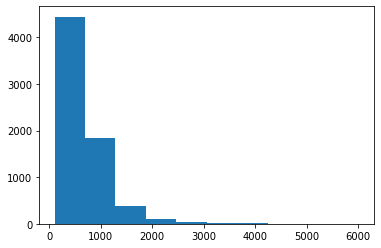

In [ ]:
plt.hist(char_lens)
plt.show()

In [ ]:
np.percentile(char_lens, 95)

1525.0

In [ ]:
import string
alphabets = string.ascii_lowercase + string.digits + string.punctuation

In [ ]:
alphabets

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
char_tokens = len(alphabets) + 2

In [ ]:
char_vect = keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens = char_tokens, 
    output_sequence_length=1525,
    pad_to_max_tokens=True
)

In [ ]:
char_vect.adapt(train_chars)

In [ ]:
char_vocab = char_vect.get_vocabulary()
char_vocab[:10], char_vocab[-10:], len(char_vocab)

(['', '[UNK]', 'e', 'a', 't', 'i', 'o', 'n', 's', 'r'],
 ['♥', 'ो', 'े', 'र', 'म', 'ñ', '¥', '👍', '⭐', '😘'],
 70)

In [ ]:
char_embed = keras.layers.Embedding(
    input_dim=len(char_vocab),
    output_dim=128, mask_zero=True
)

In [ ]:
train_chars_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
val_chars_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
inputs = keras.layers.Input(shape=(1,), dtype=tf.string)
x = char_vect(inputs)
x = char_embed(x)
x = keras.layers.Conv1D(128, 5, activation="relu")(x)
x = keras.layers.MaxPool1D(pool_size=2)(x)
x = keras.layers.Conv1D(256, 10, activation="relu")(x)
x = keras.layers.GRU(64, return_sequences=True)(x)
x = keras.layers.GRU(128, return_sequences=True)(x)
x = keras.layers.GlobalMaxPooling1D()(x)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(4, activation="softmax")(x)

model_6 = keras.Model(inputs, outputs)

model_6.compile(loss=keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"],
                optimizer=keras.optimizers.Adam())

history_model_6 = model_6.fit(train_chars_dataset, epochs=10, steps_per_epoch=len(train_chars_dataset),
                              validation_data=val_chars_dataset, validation_steps=len(val_chars_dataset))

Epoch 1/10
215/215 [==============================] - 23s 91ms/step - loss: 0.9198 - accuracy: 0.6153 - val_loss: 0.5910 - val_accuracy: 0.7772
Epoch 2/10
215/215 [==============================] - 19s 88ms/step - loss: 0.4849 - accuracy: 0.8230 - val_loss: 0.4605 - val_accuracy: 0.8336
Epoch 3/10
215/215 [==============================] - 19s 88ms/step - loss: 0.3584 - accuracy: 0.8752 - val_loss: 0.4420 - val_accuracy: 0.8427
Epoch 4/10
215/215 [==============================] - 19s 88ms/step - loss: 0.2823 - accuracy: 0.9091 - val_loss: 0.4470 - val_accuracy: 0.8362
Epoch 5/10
215/215 [==============================] - 19s 88ms/step - loss: 0.2135 - accuracy: 0.9286 - val_loss: 0.4036 - val_accuracy: 0.8847
Epoch 6/10
215/215 [==============================] - 19s 88ms/step - loss: 0.1719 - accuracy: 0.9436 - val_loss: 0.4294 - val_accuracy: 0.8716
Epoch 7/10
215/215 [==============================] - 19s 88ms/step - loss: 0.1264 - accuracy: 0.9535 - val_loss: 0.5442 - val_accuracy:

In [ ]:
model_6.evaluate(val_chars_dataset)

24/24 [==============================] - 1s 41ms/step - loss: 0.4992 - accuracy: 0.8794


[0.4992009103298187, 0.8794233202934265]

In [ ]:
model_6_preds = tf.argmax(model_6.predict(test_df['STORY'].to_numpy()), axis=1)
model_6_df = pd.DataFrame(model_6_preds)
model_6_df.columns = ["SECTION"]

In [ ]:
model_6_df.to_csv("model_6_preds.csv", index=False)

### Model 7 - Token Level embeddings + character level embeddings multi input hybrid model